Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 3: ES

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES

## Instructions

* Create the directory `lab2` inside the course repo 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



In [524]:
import logging
from pprint import pprint, pformat
from collections import namedtuple
import random
from copy import deepcopy
import math
from copy import copy
from dataclasses import dataclass
from random import random, choice, randint
import matplotlib.pyplot as plt


## The *Nim* and *Nimply* classes

In [525]:
Nimply = namedtuple("Nimply", "row, num_objects")
genoma = {"rows": 0, "elements": 0}
evolve_info ={"genoma" : genoma, "sigma_r": 0.2, "sigma_t": 0.3}

NUM_GENERATION = 50
NUM_POPULATION = 100
NUM_AGENT_TO_MUTATE = 40
MUTATION = 0.15
NUM_PARENTS = 2
N = 5



In [526]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects


## Sample (and silly) startegies 

In [527]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = randint(1, state.rows[row])
    return Nimply(row, num_objects)


In [528]:
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))


In [529]:
import numpy as np


def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)


def analize(raw: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = nim_sum(tmp)
    return cooked


def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = choice(spicy_moves)
    return ply


In [530]:
def agent_startegy(state: Nim, agent_genotype ) -> Nimply:
    
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    (row,tessere) = Nimply(*max(possible_moves, key=lambda m: ((m[0]+agent_genotype[0]), (m[1]+agent_genotype[1]))))
    if row > state.rows[0] and  tessere < 0:
        return Nimply(*max(possible_moves, key=lambda m: ((m[0]), (m[1]))))
    elif row > state.rows[0]:
        return Nimply(*max(possible_moves, key=lambda m: ((m[0]), (m[1]+agent_genotype[1]))))
    elif tessere < 0:
        return Nimply(*max(possible_moves, key=lambda m: ((m[0]+agent_genotype[0]), (m[1]+agent_genotype[1]))))
    return Nimply(*max(possible_moves, key=lambda m: ((m[0]+agent_genotype[0]), (m[1]+agent_genotype[1]))))

In [531]:
def play(agent_genotype, opponent):
    win  = 0
    for _ in range(0,100):
        player = 0
        nim = Nim(N)
        while nim:
            if player == 0:
                ply=opponent(nim)
            else:
                ply=agent_startegy(nim, agent_genotype)
            nim.nimming(ply)
            player = 1 - player
        if player == 1:
            win +=1
    return win/100


In [532]:
@dataclass
class Agent:
    fitness: float
    genotype: list[int]

In [533]:
def select_parent(pop):
    pool = [choice(pop) for _ in range(NUM_PARENTS)]
    champion = max(pool, key=lambda i: i.fitness)
    return champion

In [534]:
def mutate(agent: Agent, opponent) -> Agent:
    offspring = copy(agent)
    gene_to_mutate = randint(0, len(offspring.genotype)-1)
    mutation = -1 #choice((1,-1)) -1
    offspring.genotype[gene_to_mutate] = offspring.genotype[gene_to_mutate] + mutation 
    offspring.fitness = play(offspring.genotype, opponent)
    return offspring

In [535]:
def xover(p1: Agent, p2: Agent):
        gene_from_p1 = randint(0, len(p1.genotype)-1)
        gene_from_p2 = 1-gene_from_p1
        return Agent(fitness=0, genotype=[p1.genotype[gene_from_p1], p2.genotype[gene_from_p2]])


In [536]:
def find_best_agent(opponent):
    fitness_list = []
    population = [Agent(
        genotype =  [-randint(0,N-1),0],#[choice((1,-1))*randint(0,N-1), choice((1,-1))*randint(0, (N-1)*2)], 
        fitness = 0,
        ) for _ in range(NUM_POPULATION)]
    for a in population:
        a.fitness = play(a.genotype, opponent)
    print("NEW ALGO\n")
    print(population)

    for generation in range(NUM_GENERATION):
        next_gen = list()
        for agent_to_mutate in range(NUM_AGENT_TO_MUTATE):
            if random() < MUTATION:  # self-adapt mutation probability
                p = select_parent(population)
                o = mutate(p, opponent)
            else:
                p1 = select_parent(population)
                p2 =select_parent(population)
                o = xover(p1,p2)
            next_gen.append(o)

        for a in next_gen:
             a.fitness = play(a.genotype, opponent)
        population.extend(next_gen)
        population.sort(key=lambda i: i.fitness, reverse=True)
        population = population[:NUM_POPULATION]
        print(population[0].fitness)
        fitness_list.append(population[0].fitness)
    generations = list(range(1, len(fitness_list) + 1))
    plt.plot(generations, fitness_list, marker='o', linestyle='-', color='b')
    plt.title('Fitness Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.grid(True)
    plt.show()  
    return population[0]


In [537]:
def compute_avarage_win_rate(best_agent):
    #best_agent  = Agent(fitness=0, genotype=[-2,-1])
    nim = Nim(N)
    opponent = optimal
    player = 0
    win = 0
    win_rate = []
    for batch in range(10):
        win =0
        for i in range(100):
            nim = Nim(N)
            player = 0
            while nim:
                if player == 0:
                    ply = opponent(nim)
                else:
                    ply=agent_startegy(nim, best_agent.genotype)
                logging.info(f"ply: player {player} plays {ply}")
                nim.nimming(ply)
                logging.info(f"status: {nim}")
                player = 1 - player
            if player == 1:
                win+=1
        win_rate.append(win)
    batches = list(range(1, len(win_rate) + 1))
    np_winrate =np.array(win_rate)
    avarage = np.mean(np_winrate)
    print("AVARAGE OF 1000 GAMES: ", avarage)

    plt.bar(batches, win_rate)
    plt.title('Win rate over 1000 games')
    plt.xlabel('100 Games Grouped')
    plt.ylabel('Win rate %')
    plt.grid(True)
    plt.show()  
    
            

## Oversimplified match

NEW ALGO

[Agent(fitness=0.32, genotype=[-2, 0]), Agent(fitness=0.38, genotype=[0, 0]), Agent(fitness=0.33, genotype=[-3, 0]), Agent(fitness=0.4, genotype=[-3, 0]), Agent(fitness=0.35, genotype=[-4, 0]), Agent(fitness=0.44, genotype=[-4, 0]), Agent(fitness=0.43, genotype=[-2, 0]), Agent(fitness=0.44, genotype=[-4, 0]), Agent(fitness=0.47, genotype=[-4, 0]), Agent(fitness=0.38, genotype=[-4, 0]), Agent(fitness=0.42, genotype=[-3, 0]), Agent(fitness=0.39, genotype=[-3, 0]), Agent(fitness=0.46, genotype=[-3, 0]), Agent(fitness=0.36, genotype=[-1, 0]), Agent(fitness=0.5, genotype=[-3, 0]), Agent(fitness=0.42, genotype=[0, 0]), Agent(fitness=0.42, genotype=[0, 0]), Agent(fitness=0.42, genotype=[-4, 0]), Agent(fitness=0.35, genotype=[0, 0]), Agent(fitness=0.38, genotype=[0, 0]), Agent(fitness=0.38, genotype=[-3, 0]), Agent(fitness=0.48, genotype=[-1, 0]), Agent(fitness=0.54, genotype=[-1, 0]), Agent(fitness=0.47, genotype=[-1, 0]), Agent(fitness=0.47, genotype=[-3, 0]), Agent(fitness=0.43, g

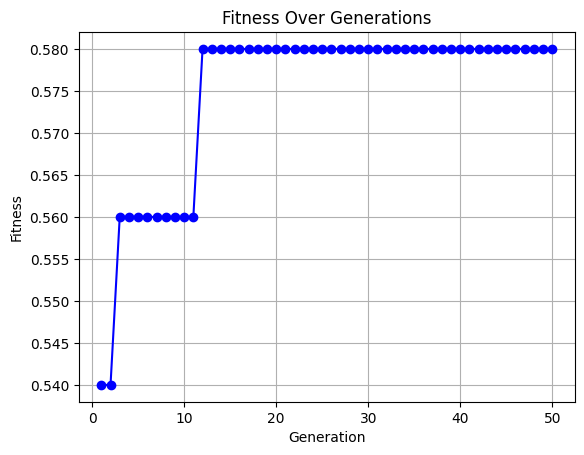

INFO:root:ply: player 0 plays Nimply(row=3, num_objects=5)
INFO:root:status: <1 3 5 2 9>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=9)
INFO:root:status: <1 3 5 2 0>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=1)
INFO:root:status: <1 3 5 1 0>
INFO:root:ply: player 1 plays Nimply(row=3, num_objects=1)
INFO:root:status: <1 3 5 0 0>
INFO:root:ply: player 0 plays Nimply(row=1, num_objects=1)
INFO:root:status: <1 2 5 0 0>
INFO:root:ply: player 1 plays Nimply(row=2, num_objects=5)
INFO:root:status: <1 2 0 0 0>
INFO:root:ply: player 0 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 2 0 0 0>
INFO:root:ply: player 1 plays Nimply(row=1, num_objects=2)
INFO:root:status: <0 0 0 0 0>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=2)
INFO:root:status: <1 3 5 7 7>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=7)
INFO:root:status: <1 3 5 7 0>
INFO:root:ply: player 0 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 3 5 7 0>
INFO:root:ply: player

AVARAGE OF 1000 GAMES:  35.4


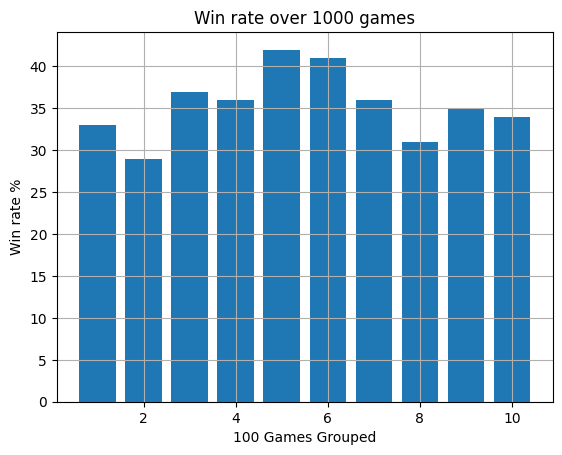

INFO:root:init : <1 3 5 7 9>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=9)
INFO:root:status: <1 3 5 7 0>
INFO:root:ply: player 1 plays Nimply(row=3, num_objects=7)
INFO:root:status: <1 3 5 0 0>
INFO:root:ply: player 0 plays Nimply(row=1, num_objects=3)
INFO:root:status: <1 0 5 0 0>
INFO:root:ply: player 1 plays Nimply(row=2, num_objects=5)
INFO:root:status: <1 0 0 0 0>
INFO:root:ply: player 0 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 0 0 0 0>
INFO:root:ply: player 0 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 3 5 7 9>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=9)
INFO:root:status: <0 3 5 7 0>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=6)
INFO:root:status: <0 3 5 1 0>
INFO:root:ply: player 1 plays Nimply(row=3, num_objects=1)
INFO:root:status: <0 3 5 0 0>
INFO:root:ply: player 0 plays Nimply(row=2, num_objects=2)
INFO:root:status: <0 3 3 0 0>
INFO:root:ply: player 1 plays Nimply(row=2, num_objects=3)
INFO:root:status: <0 3

In [538]:
#find_best_generation()
nim = Nim(N)
opponent = pure_random
best_agent = find_best_agent(opponent)
compute_avarage_win_rate(best_agent)
#best_agent  = Agent(fitness=0, genotype=[0,-2])
logging.getLogger().setLevel(logging.INFO)


logging.info(f"init : {nim}")
player = 0
win = 0
for i in range(100):
    nim = Nim(N)
    player = 0
    while nim:
        if player == 0:
            ply = opponent(nim)
        else:
            ply=agent_startegy(nim, best_agent.genotype)
        logging.info(f"ply: player {player} plays {ply}")
        nim.nimming(ply)
        logging.info(f"status: {nim}")
        player = 1 - player
    if player == 1:
        win+=1

logging.info(f"Best Agent won: {(win/100)*100}% of matches")
logging.info(f"Best Agent Genotype: {best_agent.genotype}")




